In [1]:
### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
import hdbscan
from sklearn.metrics import davies_bouldin_score

In [2]:
### Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

In [64]:
### Data introduction
# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

# Split training and testing data
def split_data(df: pd.DataFrame, target: str) -> tuple:
    X = df.copy()
    Y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1/3)
    return x_train, x_test, y_train, y_test

# Sampling

def oversample(df: pd.DataFrame, target: str) -> pd.DataFrame:
    x = df.drop(columns=target)
    y = df[target]

    ROS = RandomOverSampler(sampling_strategy="auto")
    x_res, y_res = ROS.fit_resample(x, y)
    return x_res, y_res

def sampling(df: pd.DataFrame, rate: float, cap1=0, cap2=0, notext=False) -> pd.DataFrame:
    if notext == False:
        print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
        print("Sampling ...")

    if cap1 != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        if cap2 != 0:
            subtypes_sampling1 = subtype_counts[(subtype_counts > cap1) & (subtype_counts < 10*cap2)].index
            subtypes_sampling2 = subtype_counts[subtype_counts >= 10*cap2].index
        
        else:
             subtypes_sampling = subtype_counts[subtype_counts > cap1].index
        subtypes_nosampling = subtype_counts[subtype_counts <= cap1].index # All the traffic subtypes with under x rows
        
        if cap2 != 0:
            df_sampling1 = df[df["Traffic Subtype"].isin(subtypes_sampling1)]
            df_sampled1 = df_sampling1.sample(frac=rate)
            df_sampling2 = df[df["Traffic Subtype"].isin(subtypes_sampling2)]
            df_sampled2 = df_sampling2.sample(frac=rate/10)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled1, df_sampled2, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

        else:
            df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]
            df_sampled = df_sampling.sample(frac=rate)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)
        
    if notext == False:
        print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final.sample(frac=1, ignore_index=True)

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame, target: str):
    print("\n\nSampled dataset with target:", target)
    print("Dataset after uniform target sampling has", df.shape[0], "rows and", df.shape[1], "columns")
    display(df.head())
    display(df.tail())
    display(df.describe().T)
    display(df.groupby([target]).size().reset_index(name="Counts"))
    display(df.groupby(TARGET_LABELS).size().reset_index(name="Counts"))

In [39]:
### Correlation, target correlation and intresting columns
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}
SUBTYPES_MAPPER = {
    "Audio": 0, "Background": 1, "Text": 2, "Video HTTP": 3, "Video RTP": 4, "Video UDP": 5, "Bruteforce DNS": 6, "Bruteforce FTP": 7, "Bruteforce HTTP": 8,
    "Bruteforce SSH": 9, "Bruteforce Telnet": 10, "DoS ACK": 11, "DoS CWR": 12, "DoS ECN": 13, "DoS FIN": 14, "DoS HTTP": 15, "DoS ICMP": 16, "DoS MAC": 17,
    "DoS PSH": 18, "DoS RST": 19, "DoS SYN": 20, "DoS UDP": 21, "DoS URG": 22, "Information Gathering": 23, "Mirai DDoS ACK": 24, "Mirai DDoS DNS": 25,
    "Mirai DDoS GREETH": 26, "Mirai DDoS GREIP": 27, "Mirai DDoS HTTP": 28, "Mirai DDoS SYN": 29, "Mirai DDoS UDP": 30, "Mirai Scan Bruteforce": 31
    }

def labels_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def subtypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Subtype"] = df_copy["Traffic Subtype"].map(mapper)
    return df_copy


def correlation(df_numerical: pd.DataFrame, target=False):
    if target == True:
        important_metrics_label = []
        important_metrics_ttype = []
        df_copy = df_numerical.copy()
        df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())
        cor = df_norm.corr(numeric_only=True).filter(["Label", "Traffic Type"])

        for r in cor.index.tolist():
            if abs(cor.at[r, "Label"]) > 0.25:
                important_metrics_label.append(r)
            if abs(cor.at[r, "Traffic Type"]) > 0.25:
                important_metrics_ttype.append(r)

        print(len(important_metrics_label), "Metrics with high correlation with Label")
        print(len(important_metrics_ttype), "Metrics with high correlation with Traffic Type")
        return cor, important_metrics_label, important_metrics_ttype

    else:
        df_copy = df_numerical.copy()
        df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())
        return df_norm.corr(numeric_only=True)

In [82]:
### Data Visualization
# Create heatmap from correlation Pandas Dataframe
def heatmap(corr: pd.DataFrame, title: str) -> None:
    print("Generating heatmap ...")
    plt.figure(figsize=(30, 20))
    sns.heatmap(corr, cmap="coolwarm", square=True)
    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, title: str, y_lim_bot: float, y_lim_top: float, x_labels: list) -> None:
    print("Generating boxplot ...")
    df_copy = df.copy()
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_copy)
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df_scaled)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right", labels=x_labels, ticks=[i for i in range(len(x_labels))])
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()



In [41]:
### Dimensionality Reduction
PCA_COLS = [
    "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17",
    "PC18", "PC19", "PC20", "PC21", "PC22", "PC23", "PC24", "PC25", "PC26", "PC27", "PC28", "PC29", "PC30"
    ]

def dim_reduction(df: pd.DataFrame, N: int, method: str) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])
        print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [78]:
### Clustering
# BIRCH Algorithm
def BIRCH_clustering(df: pd.DataFrame, N_clusters: int) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    model = Birch(n_clusters=N_clusters)
    model.fit(df_scaled)
    df["Cluster"] = model.labels_
    cluster_index = davies_bouldin_score(df, model.labels_)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# HDBSCAN Algorithm
def HDBSCAN_clustering(df: pd.DataFrame, minimum_cluster_size: int) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    model = hdbscan.HDBSCAN(min_cluster_size=minimum_cluster_size)
    clusters = model.fit_predict(df_scaled)
    df["Cluster"] = clusters
    df_clean = df[df["Cluster"] != -1]
    clusters_clean = df_clean["Cluster"].to_numpy()
    cluster_index = davies_bouldin_score(df_clean, clusters_clean)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# Evaluation of clusters
def evaluate_clusters(df: pd.DataFrame, target: str, subtarget: str, targets_n: int):
    prediction_list = []
    counts = {}
    problematic_count = 0
    problematic_idx_count = {i: 0 for i in range(targets_n)}
    problematic_pop = 0
    total_pop = len(df)
    total_clusters = df["Cluster"].nunique()
    target_total_pop = {i: 0 for i in range(targets_n)}
    target_actual_pop = {i: 0 for i in range(targets_n)}

    for cluster_id in range(total_clusters):
        class_counts = [len(df[(df["Cluster"] == cluster_id) & (df[target] == j)]) for j in range(targets_n)]
        if sum(class_counts) == 0:
            continue
        dominant_class = np.argmax(class_counts)
        dominant_count = class_counts[dominant_class]
        other_count = sum(class_counts) - dominant_count
        prediction_list.append(dominant_class)
        if dominant_count == 0:
            continue
        ratio = other_count / dominant_count
        if ratio > 0.2:
            problematic_count += 1
            problematic_pop += sum(class_counts)
            problematic_idx_count[dominant_class] += 1
        target_total_pop[dominant_class] += sum(class_counts)

    for i in range(targets_n):
        counts[i] = prediction_list.count(i)

    for i in range(targets_n):
        target_actual_pop[i] = len(df[df[target] == i])

    print("Problematic Cluster Ratio:", problematic_count / total_clusters)
    print("Problematic Population Ratio:", problematic_pop / total_pop)
    print("Clusters assigned to each", target, "-->", counts)
    print("Problematic Clusters assigned to each", target, "-->", problematic_idx_count)
    print("Total Clusters -->", total_clusters)
    print("Total Population predicted per Target -->", target_total_pop)
    print("Actual population per Target -->", target_actual_pop)

    df_plot_x = df.groupby("Cluster")[target].mean()
    df_plot_y = df.groupby("Cluster")[subtarget].mean()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_plot_x.values, df_plot_y.values, c="red", marker="x", s=100, label="Cluster Centers")
    if target == "Label":
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.5, 7.5))
    elif target == "Traffic Type":
        plt.xlim((-0.5, 7.5))
        plt.ylim((-1, 32))
    plt.xlabel(target)
    plt.ylabel(subtarget)
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [104]:
### Initial undersampling/oversampling remove excess metrics and duplicates in order to create plots in reasonable time, present data
ttype_list = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]

df_sampled = sampling(df_data, rate=0.005, cap1=5000, cap2=0)
df_sampled = drop_unnecessary(df_sampled)

split_list_label = split_data(df_sampled, "Label")
df_train_label = split_list_label[0]
df_test_label = split_list_label[1]

split_list_ttype = split_data(df_sampled, "Traffic Type")
df_train_ttype = split_list_label[0]
df_test_ttype = split_list_label[1]

df_smoothed_label, y_train_label = oversample(df_train_label, "Label")
df_smoothed_label["Label"] = y_train_label
df_smoothed_label_benign = df_smoothed_label[df_smoothed_label["Label"] == "Benign"]
df_smoothed_label_malicious = df_smoothed_label[df_smoothed_label["Label"] == "Malicious"]
df_smoothed_label_final_b, y_train_label_final_b = oversample(df_smoothed_label_benign, "Traffic Type")
df_smoothed_label_final_b["Traffic Type"] = y_train_label_final_b
df_smoothed_label_final_m, y_train_label_final_m = oversample(df_smoothed_label_malicious, "Traffic Type")
df_smoothed_label_final_m["Traffic Type"] = y_train_label_final_m
df_smoothed_label_final = pd.concat([df_smoothed_label_final_b, df_smoothed_label_final_m], ignore_index=True)
df_smoothed_label_final = df_smoothed_label_final.sample(frac=1)

df_smoothed_ttype, y_train_ttype = oversample(df_train_label, "Traffic Type")
df_smoothed_ttype["Traffic Type"] = y_train_ttype

df_label = sampling(df_smoothed_label_final, rate=0.3, notext=True)
df_ttype = sampling(df_smoothed_ttype, rate=0.3, notext=True)

present(df_label, "Label")
present(df_ttype, "Traffic Type")

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 61467 rows and 86 columns
Dataset before removing unnecessary data has 61467 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 61467 rows and 80 columns


Sampled dataset with target: Label
Dataset after uniform target sampling has 61963 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00       36609.00              1.00               1.00   
1      6.00   114102083.00           4029.00            4100.00   
2      6.00    24871827.00              2.00               1.00   
3      6.00   119121065.00            101.00              67.00   
4      6.00    21054197.00             32.00              25.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                      500.00                        0.00   
1                   238214.00                   302868.00   
2                      100.00                        0.00   
3                     3608.00                     7246.00   
4                     1691.00                     3449.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                 500.00                 500.00                  500.00   
1                1348.00                   0.00                   59.12   
2                  50.00                  50.00                   50.00   
3                 523.00                   0.00                   35.72   
4                 523.00                   0.00                   52.84   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   0.00                   0.00                   0.00   
1                  63.04                1348.00                   0.00   
2                   0.00                   0.00                   0.00   
3                  80.58                1348.00                   0.00   
4                 129.92                1348.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00      13657.84   
1                   73.87                  59.70       4742.09   
2                    0.00                   0.00          4.02   
3                  108.15                 175.27         91.12   
4                  137.96                 268.10        244.13   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0           54.63       36609.00          0.00      36609.00      36609.00   
1           71.24       14038.15     105126.82    4277618.00        -72.00   
2            0.12    12435913.50    1527836.43   13516257.00   11355570.00   
3            1.41      713299.79    1347598.61    6734631.00        -79.00   
4            2.71      375967.80    1213951.83    6352230.00       -175.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1   114101153.00      28327.00    149387.49   4286889.00         0.00   
2    11355570.00   11355570.00         0.00  11355570.00  11355570.00   
3   119121065.00    1191210.65   1576016.10   6740586.00        21.00   
4    21054197.00     679167.65   1578631.06   6352230.00        13.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1   114101942.00      27836.53    147793.67   4277618.00        77.00   
2           0.00          0.00         0.00         0.00         0.00   
3   118989055.00    1802864.47   1634024.94   6739418.00        89.00   
4    21048888.00     877037.00   1752719.28   6356105.00        78.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2           0.00           0.00           0.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0              20.00              20.00          27.32          27.32   
1          129008.00          131208.00          35.31  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
61958      6.00    10051411.00              7.00               6.00   
61959      6.00    10030712.00              2.00               0.00   
61960      6.00   119999322.00           4931.00            4969.00   
61961     17.00   112673452.00             24.00            6532.00   
61962      0.00    23370113.00              5.00               0.00   

       Total Length of Fwd Packet  Total Length of Bwd Packet  \
61958                       33.00                      112.00   
61959                     1000.00                        0.00   
61960                   337703.00                   357211.00   
61961                      282.00                   511032.00   
61962                        0.00                        0.00   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
61958                  21.00                   0.00                    4.71   
61959                 500.00                 500.00                  500.00   
61960                 523.00                   0.00                   68.49   
61961                  52.00                  10.00                   11.75   
61962                   0.00                   0.00                    0.00   

       Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
61958                   8.46                  77.00                   0.00   
61959                   0.00                   0.00                   0.00   
61960                  51.72                1348.00                   0.00   
61961                   8.57                 134.00                  10.00   
61962                   0.00                   0.00                   0.00   

       Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
61958                   18.67                  31.82         14.43   
61959                    0.00                   0.00         99.69   
61960                   71.89                  55.77       5790.98   
61961                   78.24                  16.71       4538.02   
61962                    0.00                   0.00          0.00   

       Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
61958            1.29      837617.58    2880039.48    9982946.00   
61959            0.20    10030712.00          0.00   10030712.00   
61960           82.50       12122.37      71747.63    3908688.00   
61961           58.19       17188.93      67119.15    3578633.00   
61962            0.21     5842528.25    9452087.67   19793760.00   

       Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
61958         25.00    10036839.00    1672806.50   4072893.57   9986550.00   
61959   10030712.00    10030712.00   10030712.00         0.00  10030712.00   
61960       -159.00   119999156.00      24340.60    101077.46   3915991.00   
61961         89.00   112118270.00    4874707.39    599390.87   5055046.00   
61962        405.00    23370113.00    5842528.25   9452087.67  19793760.00   

       Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
61958       572.00    10047270.00    2009454.00   4465477.98   9997518.00   
61959  10030712.00           0.00          0.00         0.00         0.00   
61960        26.00   119999109.00      24154.41    101185.57   3912382.00   
61961   2126182.00   112650447.00      17248.58     67236.51   3578633.00   
61962       405.00           0.00          0.00         0.00         0.00   

       Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
61958        25.00           0.00           0.00           0.00   
61959         0.00           0.00           0.00           0.00   
61960       139.00           0.00           0.00           0.00   
61961        89.00           0.00           0.00           0.00   
61962         0.00           0.00           0.00           0.00   

       Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  \
619

count        mean         std     min       25%  \
Protocol                   61963.00        6.23        4.58    0.00      6.00   
Flow Duration              61963.00 38560543.14 44298661.89    6.00 984403.50   
Total Fwd Packet           61963.00      412.53     2049.52    1.00      2.00   
Total Bwd packets          61963.00      393.02     1547.75    0.00      0.00   
Total Length of Fwd Packet 61963.00   242621.72  1527820.52    0.00      0.00   
Total Length of Bwd Packet 61963.00   109354.23   899186.49    0.00      0.00   
Fwd Packet Length Max      61963.00      214.18      374.18    0.00      0.00   
Fwd Packet Length Min      61963.00      106.94      300.06    0.00      0.00   
Fwd Packet Length Mean     61963.00      117.88      298.10    0.00      0.00   
Fwd Packet Length Std      61963.00       16.24       41.69    0.00      0.00   
Bwd Packet Length Max      61963.00      195.26      445.97    0.00      0.00   
Bwd Packet Length Min      61963.00        1.35       21.32    0.00      0.00   
Bwd Packet Length Mean     61963.00       44.56      182.24    0.00      0.00   
Bwd Packet Length Std      61963.00       29.06       80.60    0.00      0.00   
Flow Bytes/s               61963.00    14367.62    79665.12    0.00      0.00   
Flow Packets/s             61963.00     1008.53     9106.94    0.03      0.20   
Flow IAT Mean              61963.00  3593990.28  5150864.21    6.00  24521.00   
Flow IAT Std               61963.00  3398902.85  5783182.98    0.00      0.00   
Flow IAT Max               61963.00 10183820.57 13819068.72    6.00 442966.00   
Flow IAT Min               61963.00  1261197.11  3831241.11 -497.00     30.00   
Fwd IAT Total              61963.00 38081651.39 44533950.20    0.00     37.00   
Fwd IAT Mean               61963.00  3725792.76  5102965.10    0.00     37.00   
Fwd IAT Std                61963.00  3209625.87  5713787.89    0.00      0.00   
Fwd IAT Max                61963.00  9886489.81 13853955.53    0.00     37.00   
Fwd IAT Min                61963.00  1438559.33  3910721.66    0.00      0.00   
Bwd IAT Total              61963.00 18512065.20 38609731.03    0.00      0.00   
Bwd IAT Mean               61963.00   332773.22   891656.50    0.00      0.00   
Bwd IAT Std                61963.00   393232.73  1047212.81    0.00      0.00   
Bwd IAT Max                61963.00  1486619.34  2933450.25    0.00      0.00   
Bwd IAT Min                61963.00    77506.81   612195.89    0.00      0.00   
Fwd PSH Flags              61963.00        0.11        0.32    0.00      0.00   
Bwd PSH Flags              61963.00        0.00        0.00    0.00      0.00   
Fwd URG Flags              61963.00        0.03        0.16    0.00      0.00   
Bwd URG Flags              61963.00        0.00        0.00    0.00      0.00   
Fwd Header Length          61963.00     8891.73    30779.44    0.00     20.00   
Bwd Header Length          61963.00     9145.54    34138.61    0.00      0.00   
Fwd Packets/s              61963.00      969.04     9029.58    0.03      0.20   
Bwd Packets/s              61963.00       39.49      700.75    0.00      0.00   
Packet Length Min          61963.00       64.28      263.94    0.00      0.00   
Packet Length Max          61963.00      312.67      504.39    0.00      0.00   
Packet Length Mean         61963.00      121.62      287.19    0.00      0.00   
Packet Length Std          61963.00       57.94      131.67    0.00      0.00   
Packet Length Variance     61963.00    20693.56    80743.15    0.00      0.00   
FIN Flag Count             61963.00        0.29        0.60    0.00      0.00   
SYN Flag Count             61963.00        0.44        1.13    0.00      0.00   
RST Flag Count             61963.00        0.50        0.63    0.00      0.00   
PSH Flag Count             61963.00      282.42     1155.30    0.00      0.00   
ACK Flag Count             61963.00      478.19     1934.09    0.00      0.00   
URG Flag Count             61963.00        0.04        0.29  

Label  Counts
0     Benign   31954
1  Malicious   30009

Label           Traffic Type        Traffic Subtype  Counts
0      Benign                  Audio                  Audio    8004
1      Benign             Background             Background    7973
2      Benign                   Text                   Text    7969
3      Benign                  Video             Video HTTP    3364
4      Benign                  Video              Video RTP    3215
5      Benign                  Video              Video UDP    1429
6   Malicious             Bruteforce         Bruteforce DNS      76
7   Malicious             Bruteforce         Bruteforce FTP    2072
8   Malicious             Bruteforce        Bruteforce HTTP     363
9   Malicious             Bruteforce         Bruteforce SSH    2262
10  Malicious             Bruteforce      Bruteforce Telnet    2786
11  Malicious                    DoS                DoS ACK     935
12  Malicious                    DoS                DoS CWR     871
13  Malicious                    DoS                DoS ECN     858
14  Malicious                    DoS                DoS FIN     744
15  Malicious                    DoS               DoS HTTP      90
16  Malicious                    DoS               DoS ICMP       4
17  Malicious                    DoS                DoS MAC       4
18  Malicious                    DoS                DoS PSH     911
19  Malicious                    DoS                DoS RST    1050
20  Malicious                    DoS                DoS SYN     874
21  Malicious                    DoS                DoS UDP     269
22  Malicious                    DoS                DoS URG     868
23  Malicious  Information Gathering  Information Gathering    7488
24  Malicious                  Mirai         Mirai DDoS ACK    6490
25  Malicious                  Mirai         Mirai DDoS DNS     508
26  Malicious                  Mirai      Mirai DDoS GREETH      67
27  Malicious                  Mirai       Mirai DDoS GREIP      97
28  Malicious                  Mirai        Mirai DDoS HTTP      61
29  Malicious                  Mirai         Mirai DDoS SYN      78
30  Malicious                  Mirai         Mirai DDoS UDP     118
31  Malicious                  Mirai  Mirai Scan Bruteforce      65



Sampled dataset with target: Traffic Type
Dataset after uniform target sampling has 60108 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00    23767401.00              1.00               1.00   
1      6.00    12149072.00             12.00               7.00   
2      6.00       32317.00              1.00               1.00   
3      6.00     5007243.00              2.00               0.00   
4      6.00    59133244.00             59.00              39.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                      500.00                        0.00   
1                      337.00                      537.00   
2                       50.00                        0.00   
3                        0.00                        0.00   
4                     2798.00                     5254.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                 500.00                 500.00                  500.00   
1                 152.00                   0.00                   28.08   
2                  50.00                  50.00                   50.00   
3                   0.00                   0.00                    0.00   
4                 523.00                   0.00                   47.42   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   0.00                   0.00                   0.00   
1                  49.10                 154.00                  42.00   
2                   0.00                   0.00                   0.00   
3                   0.00                   0.00                   0.00   
4                 100.91                1348.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00         21.04   
1                   76.71                  41.90         71.94   
2                    0.00                   0.00       1547.17   
3                    0.00                   0.00          0.00   
4                  134.72                 229.53        136.17   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0            0.08    23767401.00          0.00   23767401.00   23767401.00   
1            1.56      674948.44    1230344.99    3874366.00        450.00   
2           61.89       32317.00          0.00      32317.00      32317.00   
3            0.40     5007243.00          0.00    5007243.00    5007243.00   
4            1.66      609621.07    1407471.60    7774709.00         27.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1    12149072.00    1104461.09   1434227.06   3874366.00       965.00   
2           0.00          0.00         0.00         0.00         0.00   
3     5007243.00    5007243.00         0.00   5007243.00   5007243.00   
4    59133244.00    1019538.69   1706955.35   7774709.00        27.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1    12140195.00    2023365.83   1379813.02   3881018.00    279403.00   
2           0.00          0.00         0.00         0.00         0.00   
3           0.00          0.00         0.00         0.00         0.00   
4    59126043.00    1555948.50   1913392.35   7778411.00       103.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           1.00           0.00           0.00           0.00   
2           0.00           0.00           1.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0              20.00              20.00           0.04           0.04   
1             384.00             224.00           0.99  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
60103      6.00          37.00              2.00               0.00   
60104      6.00      844119.00              1.00               1.00   
60105     17.00   119992639.00             25.00              25.00   
60106      6.00    75980801.00           3183.00            3223.00   
60107      6.00        3017.00              1.00               1.00   

       Total Length of Fwd Packet  Total Length of Bwd Packet  \
60103                        0.00                        0.00   
60104                       50.00                        0.00   
60105                      250.00                      250.00   
60106                   230036.00                   241345.00   
60107                        0.00                        0.00   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
60103                   0.00                   0.00                    0.00   
60104                  50.00                  50.00                   50.00   
60105                  10.00                  10.00                   10.00   
60106                 523.00                   0.00                   72.27   
60107                   0.00                   0.00                    0.00   

       Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
60103                   0.00                   0.00                   0.00   
60104                   0.00                   0.00                   0.00   
60105                   0.00                  10.00                  10.00   
60106                  49.62                1348.00                   0.00   
60107                   0.00                   0.00                   0.00   

       Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
60103                    0.00                   0.00          0.00   
60104                    0.00                   0.00         59.23   
60105                   10.00                   0.00          4.17   
60106                   74.88                  52.97       6203.95   
60107                    0.00                   0.00          0.00   

       Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
60103        54054.05          37.00          0.00         37.00   
60104            2.37      844119.00          0.00     844119.00   
60105            0.42     2448829.37    2524852.84    5003849.00   
60106           84.31       11862.73      62355.21    2710307.00   
60107          662.91        3017.00          0.00       3017.00   

       Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
60103         37.00          37.00         37.00         0.00        37.00   
60104     844119.00           0.00          0.00         0.00         0.00   
60105        211.00   119992331.00    4999680.46      2561.51   5004108.00   
60106         20.00    75980801.00      23878.32     87934.48   2710307.00   
60107       3017.00           0.00          0.00         0.00         0.00   

       Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
60103        37.00           0.00          0.00         0.00         0.00   
60104         0.00           0.00          0.00         0.00         0.00   
60105   4995828.00   119992428.00    4999684.50      2603.17   5004187.00   
60106        20.00    75977605.00      23580.88     87635.46   2713651.00   
60107         0.00           0.00          0.00         0.00         0.00   

       Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
60103         0.00           0.00           0.00           0.00   
60104         0.00           0.00           0.00           0.00   
60105   4995722.00           0.00           0.00           0.00   
60106        81.00           0.00           0.00           0.00   
60107         0.00           0.00           0.00           0.00   

       Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  \
601

count        mean         std     min       25%  \
Protocol                   60108.00        6.23        4.50    0.00      6.00   
Flow Duration              60108.00 37685512.56 44090875.29    6.00 823485.25   
Total Fwd Packet           60108.00      394.10     1604.35    1.00      2.00   
Total Bwd packets          60108.00      371.96     1397.52    0.00      0.00   
Total Length of Fwd Packet 60108.00   234481.01  1515905.63    0.00      0.00   
Total Length of Bwd Packet 60108.00   106348.21   869266.70    0.00      0.00   
Fwd Packet Length Max      60108.00      210.25      368.86    0.00      0.00   
Fwd Packet Length Min      60108.00      105.50      296.39    0.00      0.00   
Fwd Packet Length Mean     60108.00      116.23      294.51    0.00      0.00   
Fwd Packet Length Std      60108.00       16.10       41.53    0.00      0.00   
Bwd Packet Length Max      60108.00      194.19      445.57    0.00      0.00   
Bwd Packet Length Min      60108.00        1.15       16.70    0.00      0.00   
Bwd Packet Length Mean     60108.00       45.16      184.62    0.00      0.00   
Bwd Packet Length Std      60108.00       29.28       81.65    0.00      0.00   
Flow Bytes/s               60108.00    13674.29    69108.99    0.00      0.00   
Flow Packets/s             60108.00      937.47     8906.62    0.04      0.21   
Flow IAT Mean              60108.00  3573898.55  5232402.59    6.00  25424.00   
Flow IAT Std               60108.00  3317629.86  5734053.46    0.00      0.00   
Flow IAT Max               60108.00  9977648.78 13667848.93    6.00 357905.00   
Flow IAT Min               60108.00  1292941.25  3962689.54 -497.00     31.00   
Fwd IAT Total              60108.00 37183699.45 44341000.80    0.00     16.00   
Fwd IAT Mean               60108.00  3679929.74  5147235.64    0.00     16.00   
Fwd IAT Std                60108.00  3128708.72  5657596.80    0.00      0.00   
Fwd IAT Max                60108.00  9655475.97 13694910.13    0.00     16.00   
Fwd IAT Min                60108.00  1448951.83  3972123.48    0.00      0.00   
Bwd IAT Total              60108.00 18127575.32 38175615.74    0.00      0.00   
Bwd IAT Mean               60108.00   330306.75   864614.47    0.00      0.00   
Bwd IAT Std                60108.00   391079.43   976622.33    0.00      0.00   
Bwd IAT Max                60108.00  1471943.29  2792089.01    0.00      0.00   
Bwd IAT Min                60108.00    76922.07   614078.73    0.00      0.00   
Fwd PSH Flags              60108.00        0.11        0.31    0.00      0.00   
Bwd PSH Flags              60108.00        0.00        0.00    0.00      0.00   
Fwd URG Flags              60108.00        0.03        0.17    0.00      0.00   
Bwd URG Flags              60108.00        0.00        0.00    0.00      0.00   
Fwd Header Length          60108.00     8596.88    30180.47    0.00     20.00   
Bwd Header Length          60108.00     8785.17    33245.83    0.00      0.00   
Fwd Packets/s              60108.00      894.09     8791.95    0.03      0.20   
Bwd Packets/s              60108.00       43.38      836.68    0.00      0.00   
Packet Length Min          60108.00       62.65      260.41    0.00      0.00   
Packet Length Max          60108.00      309.98      502.29    0.00      0.00   
Packet Length Mean         60108.00      120.53      284.48    0.00      0.00   
Packet Length Std          60108.00       58.56      132.59    0.00      0.00   
Packet Length Variance     60108.00    21010.11    81214.61    0.00      0.00   
FIN Flag Count             60108.00        0.30        0.61    0.00      0.00   
SYN Flag Count             60108.00        0.44        0.88    0.00      0.00   
RST Flag Count             60108.00        0.51        0.63    0.00      0.00   
PSH Flag Count             60108.00      271.30     1130.66    0.00      0.00   
ACK Flag Count             60108.00      461.67     1889.51    0.00      0.00   
URG Flag Count             60108.00        0.04        0.29  

Traffic Type  Counts
0                  Audio    7505
1             Background    7592
2             Bruteforce    7450
3                    DoS    7512
4  Information Gathering    7628
5                  Mirai    7395
6                   Text    7523
7                  Video    7503

Label           Traffic Type        Traffic Subtype  Counts
0      Benign                  Audio                  Audio    7505
1      Benign             Background             Background    7592
2      Benign                   Text                   Text    7523
3      Benign                  Video             Video HTTP    3237
4      Benign                  Video              Video RTP    2921
5      Benign                  Video              Video UDP    1345
6   Malicious             Bruteforce         Bruteforce DNS      66
7   Malicious             Bruteforce         Bruteforce FTP    2029
8   Malicious             Bruteforce        Bruteforce HTTP     321
9   Malicious             Bruteforce         Bruteforce SSH    2202
10  Malicious             Bruteforce      Bruteforce Telnet    2832
11  Malicious                    DoS                DoS ACK     928
12  Malicious                    DoS                DoS CWR     887
13  Malicious                    DoS                DoS ECN     836
14  Malicious                    DoS                DoS FIN     746
15  Malicious                    DoS               DoS HTTP      87
16  Malicious                    DoS               DoS ICMP       2
17  Malicious                    DoS                DoS MAC       4
18  Malicious                    DoS                DoS PSH     905
19  Malicious                    DoS                DoS RST    1071
20  Malicious                    DoS                DoS SYN     878
21  Malicious                    DoS                DoS UDP     261
22  Malicious                    DoS                DoS URG     907
23  Malicious  Information Gathering  Information Gathering    7628
24  Malicious                  Mirai         Mirai DDoS ACK    6411
25  Malicious                  Mirai         Mirai DDoS DNS     498
26  Malicious                  Mirai      Mirai DDoS GREETH      57
27  Malicious                  Mirai       Mirai DDoS GREIP      87
28  Malicious                  Mirai        Mirai DDoS HTTP      54
29  Malicious                  Mirai         Mirai DDoS SYN      82
30  Malicious                  Mirai         Mirai DDoS UDP     139
31  Malicious                  Mirai  Mirai Scan Bruteforce      67

Generating boxplot ...


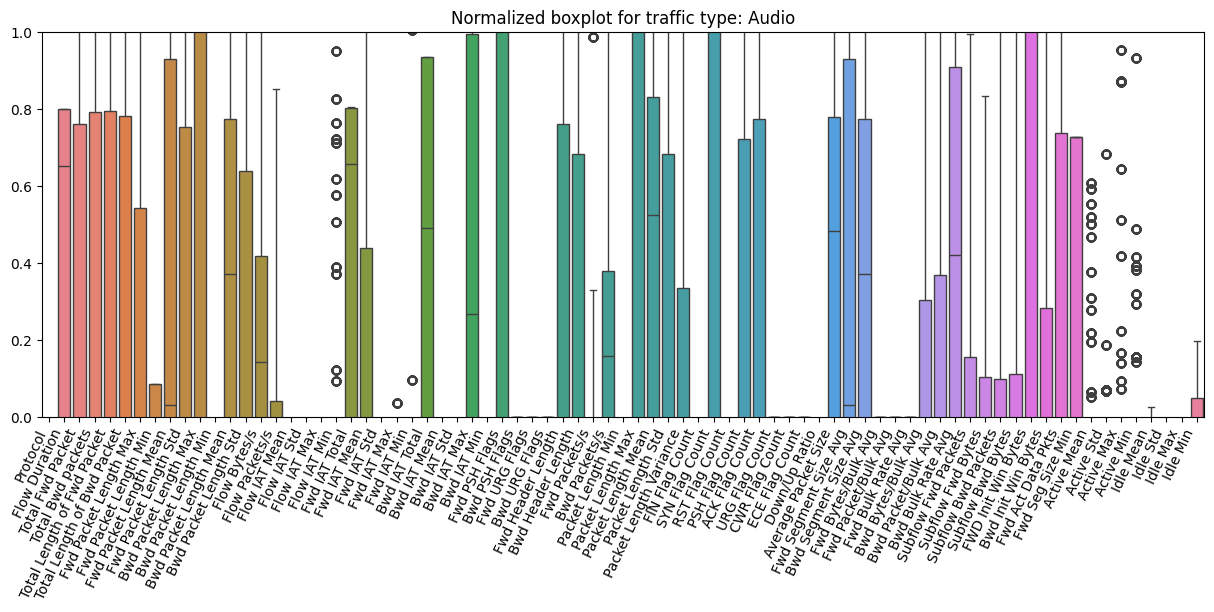

Generating boxplot ...


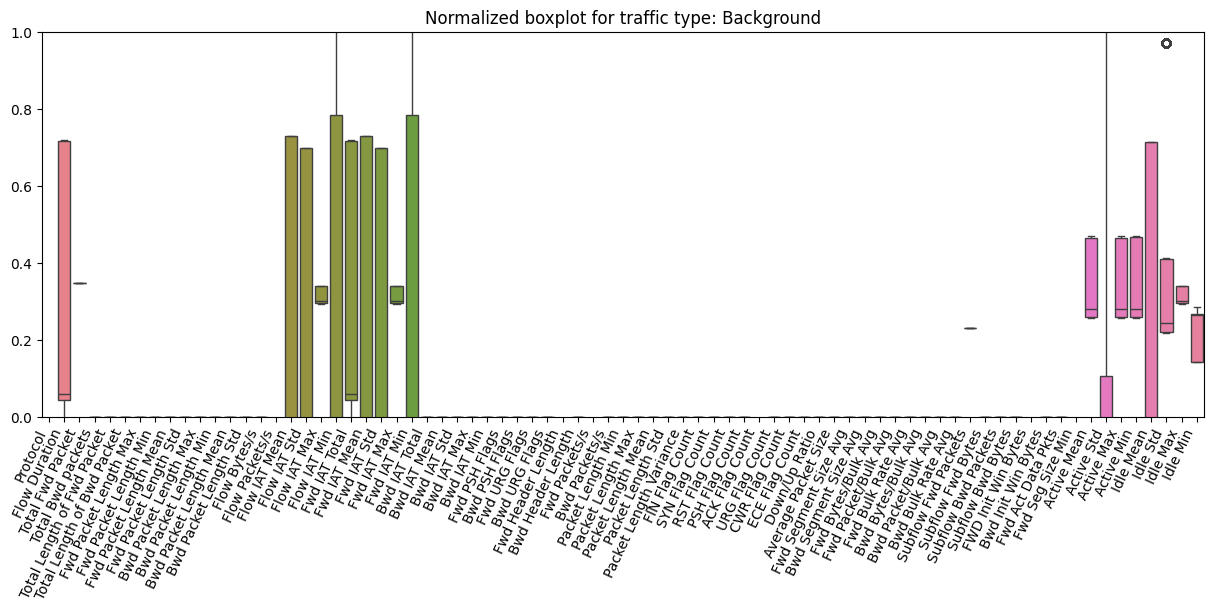

Generating boxplot ...


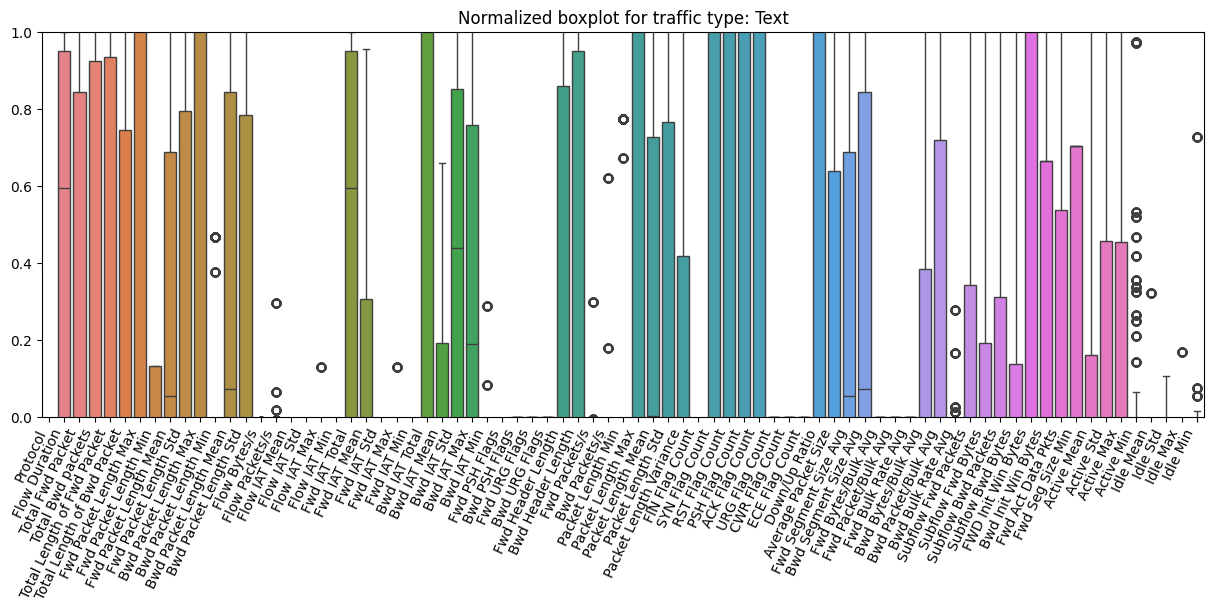

Generating boxplot ...


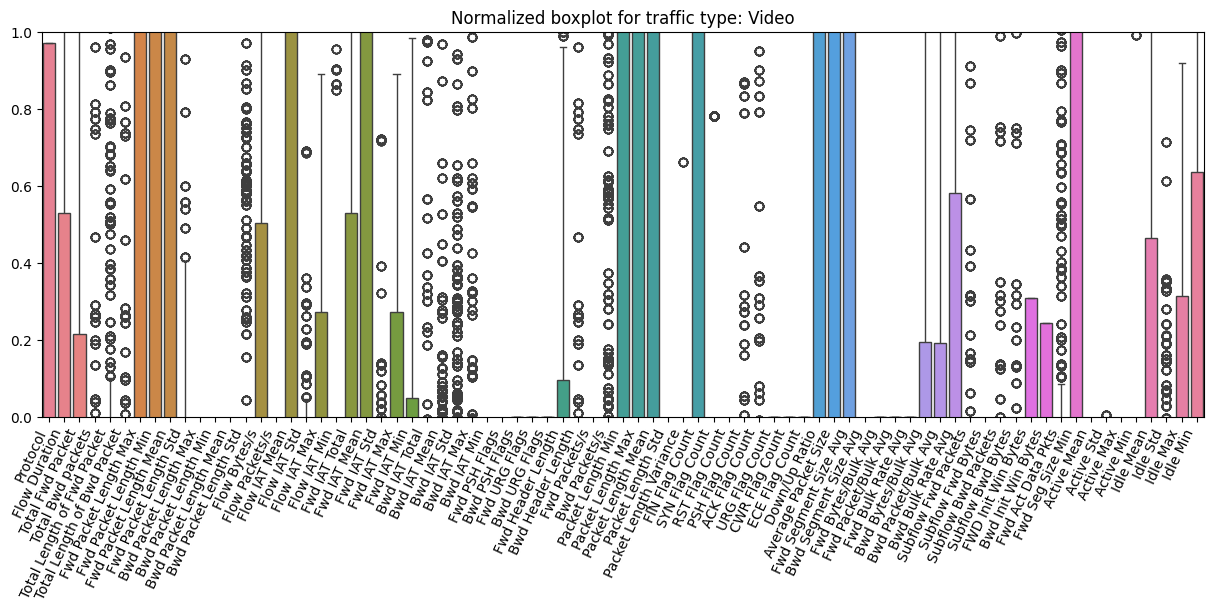

Generating boxplot ...


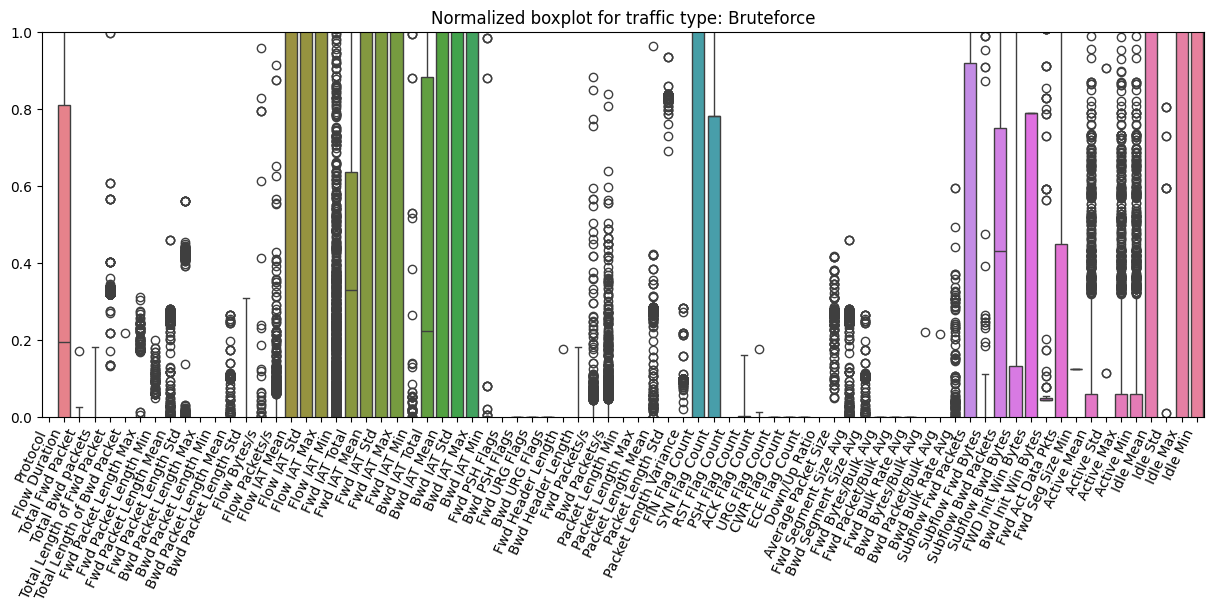

Generating boxplot ...


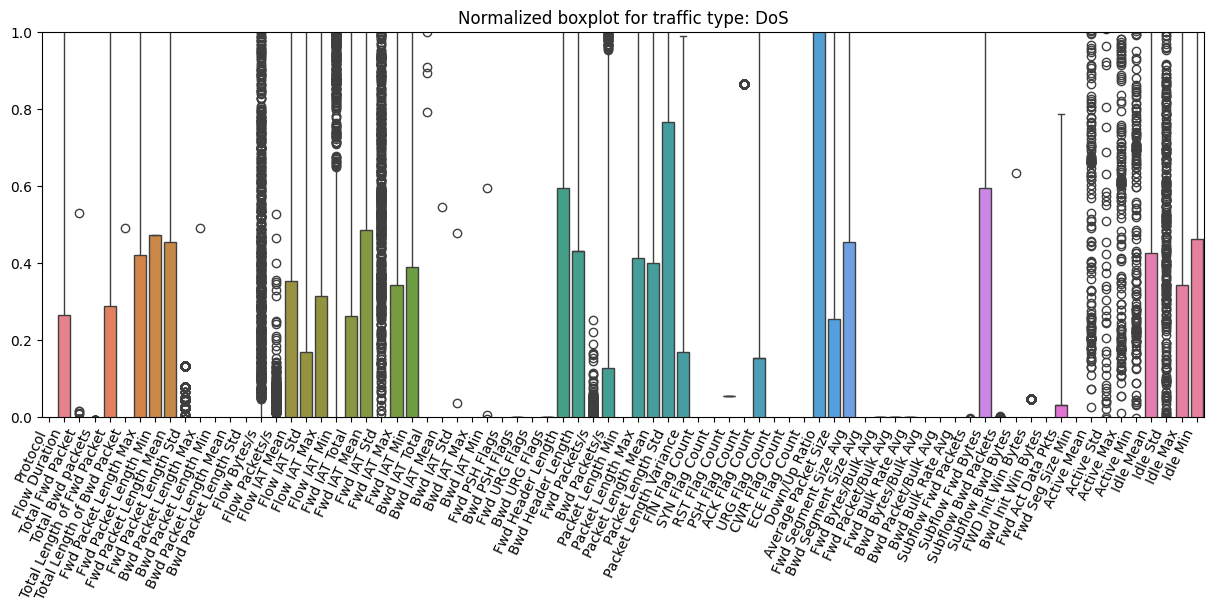

Generating boxplot ...


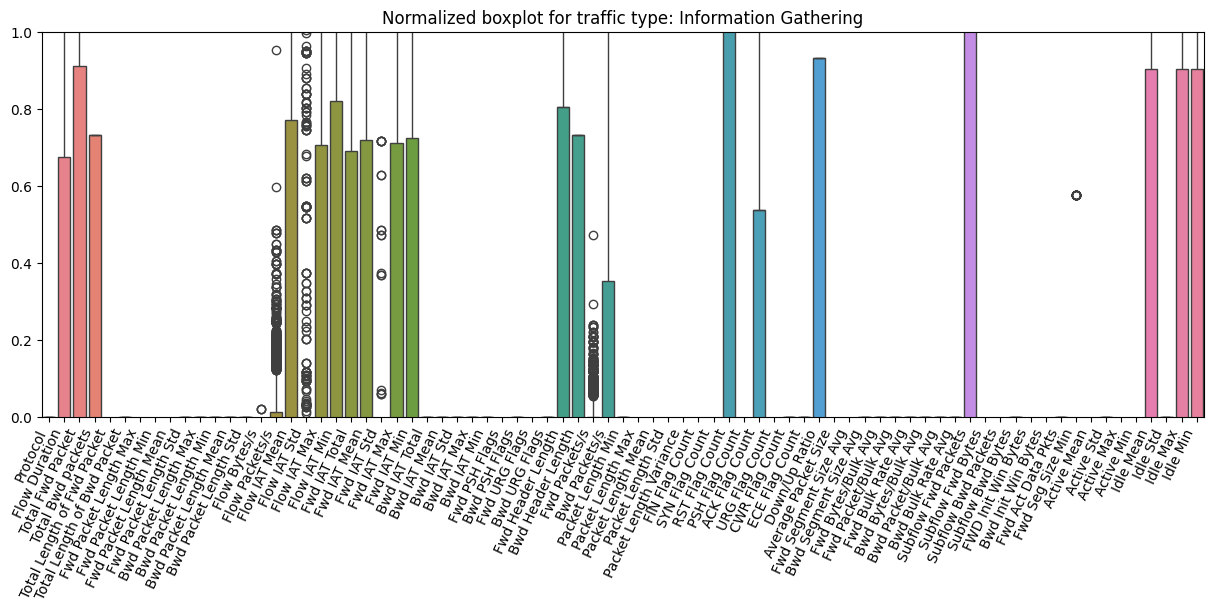

Generating boxplot ...


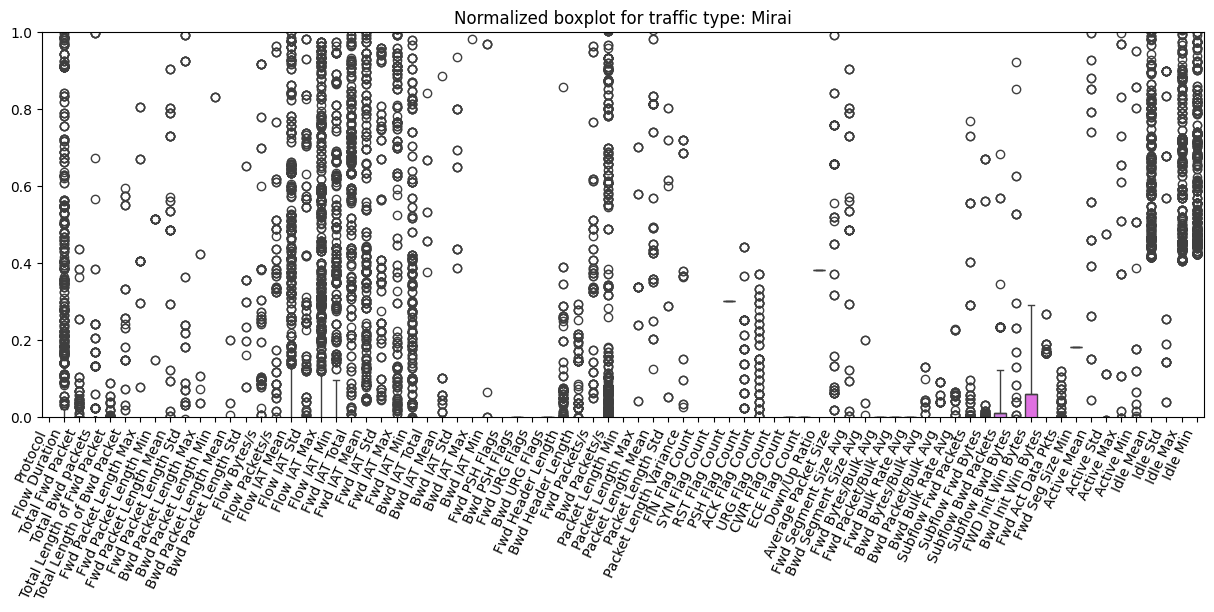

Generating boxplot ...


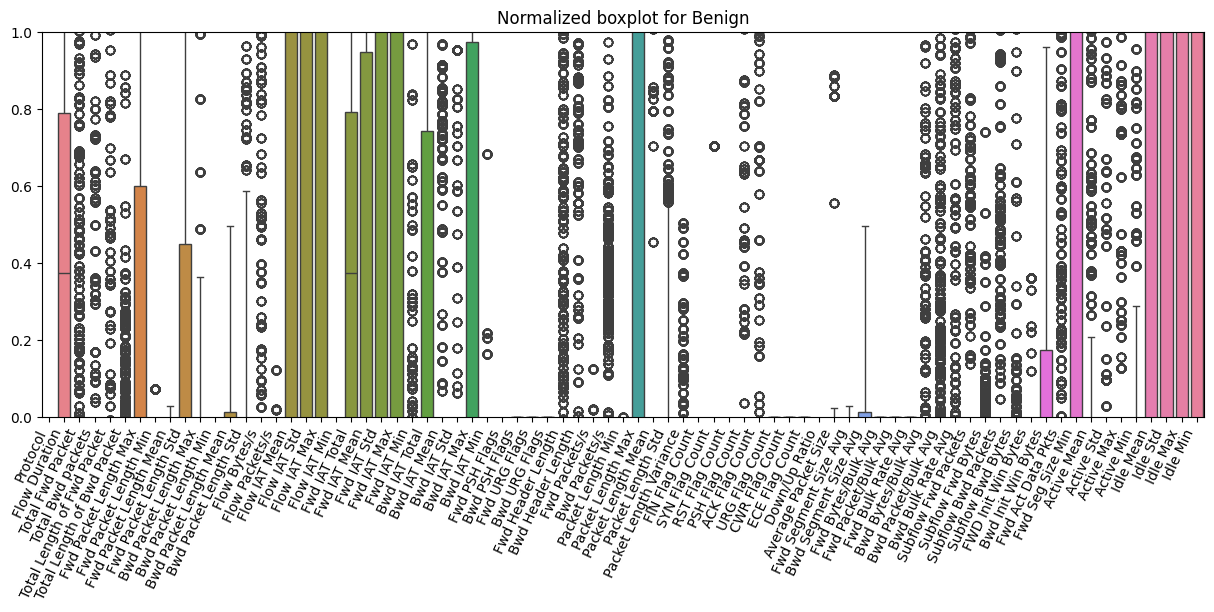

Generating boxplot ...


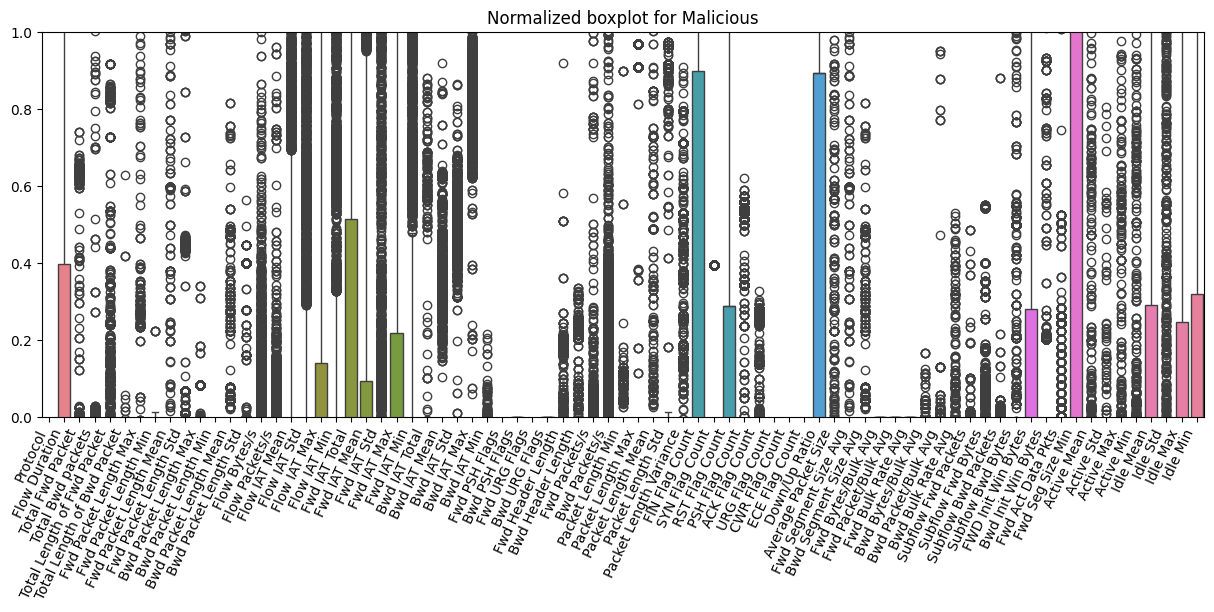

In [105]:
### Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 1
ylim_bot = 0
df_benign = df_label[df_label["Label"] == "Benign"]
df_malicious = df_label[df_label["Label"] == "Malicious"]

for ttype in ttype_list:
    boxplot(df_ttype[df_ttype["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top, df_ttype.columns.tolist()[:-3])

boxplot(df_benign.drop(columns=TARGET_LABELS), "Normalized boxplot for Benign", ylim_bot, ylim_top, df_ttype.columns.tolist()[:-3])
boxplot(df_malicious.drop(columns=TARGET_LABELS), "Normalized boxplot for Malicious", ylim_bot, ylim_top, df_ttype.columns.tolist()[:-3])

In [106]:
# Convert all data to numerical and compute correlations
df_num = labels_to_numerical(df, LABEL_MAPPER)
df_num = ttypes_to_numerical(df_num, TYPES_MAPPER)
df_num = subtypes_to_numerical(df_num, SUBTYPES_MAPPER).select_dtypes(include="number")

cor1 = correlation(df_num)
cor2, important_metrics_label, important_metrics_ttype = correlation(df_num, target=True)
label_barplot = important_metrics_label.copy()
label_barplot.remove("Traffic Type")
label_barplot.remove("Traffic Subtype")
ttype_barplot = important_metrics_ttype.copy()
ttype_barplot.remove("Label")
ttype_barplot.remove("Traffic Subtype")

14 Metrics with high correlation with Label
17 Metrics with high correlation with Traffic Type


Generating heatmap ...


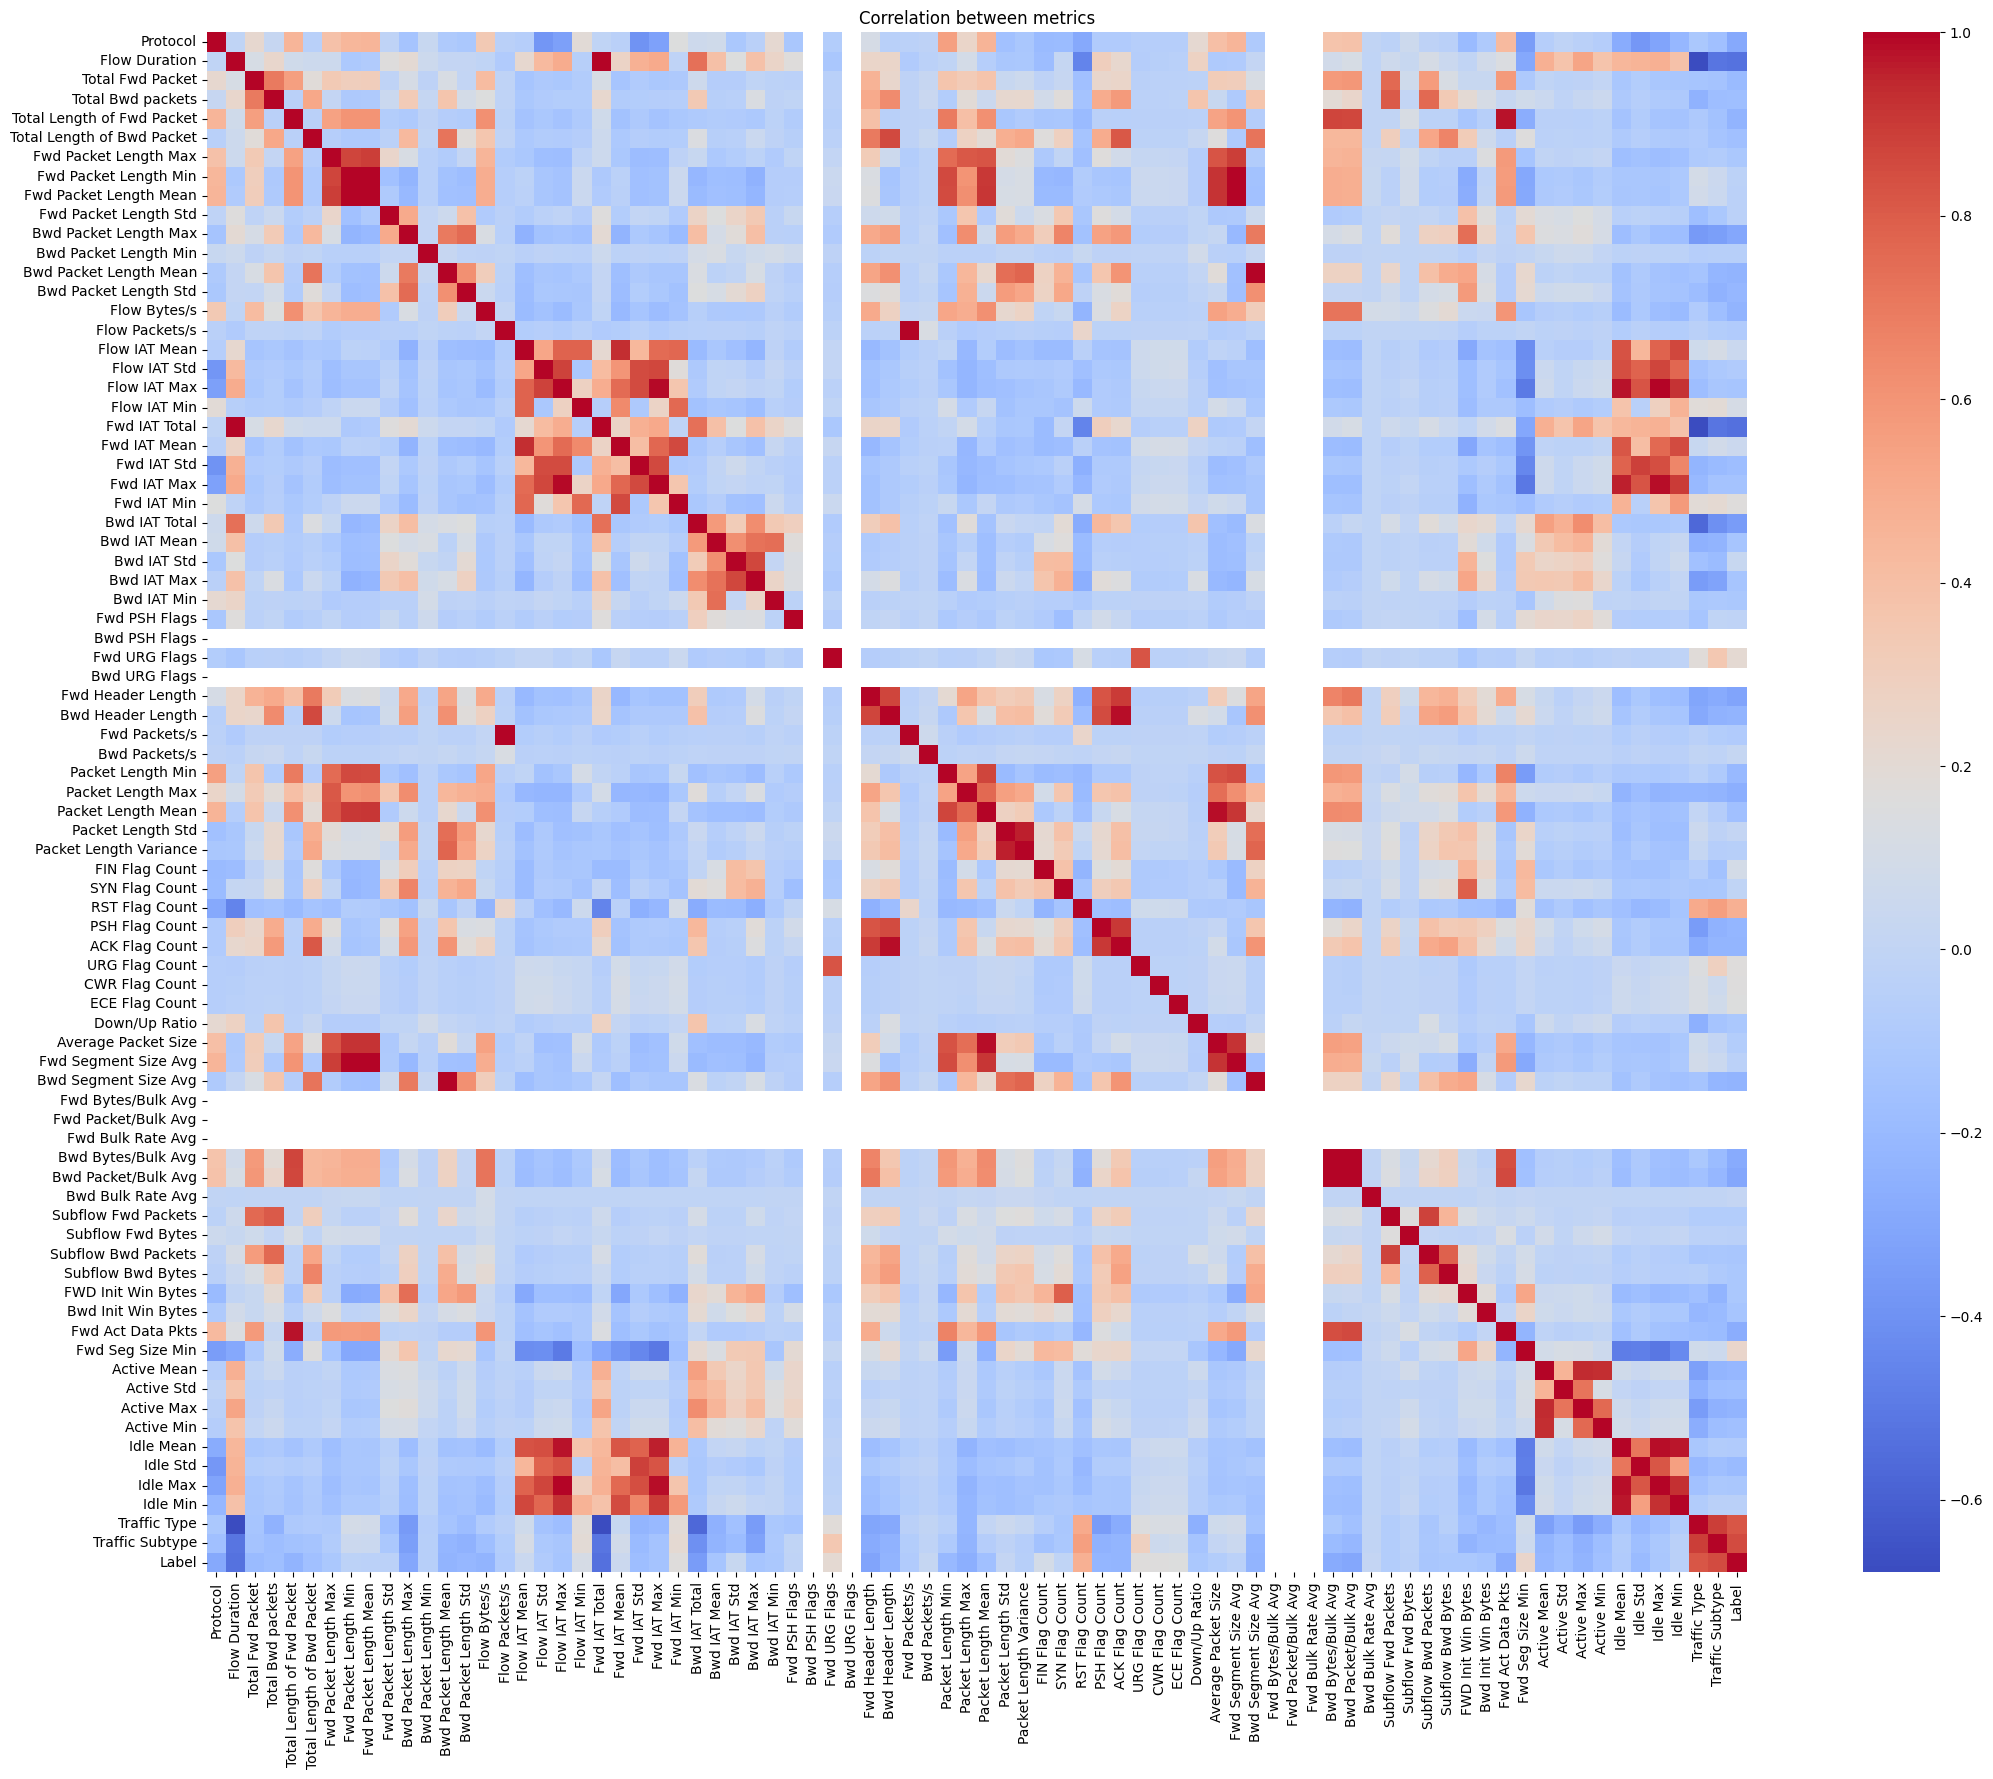

Generating heatmap ...


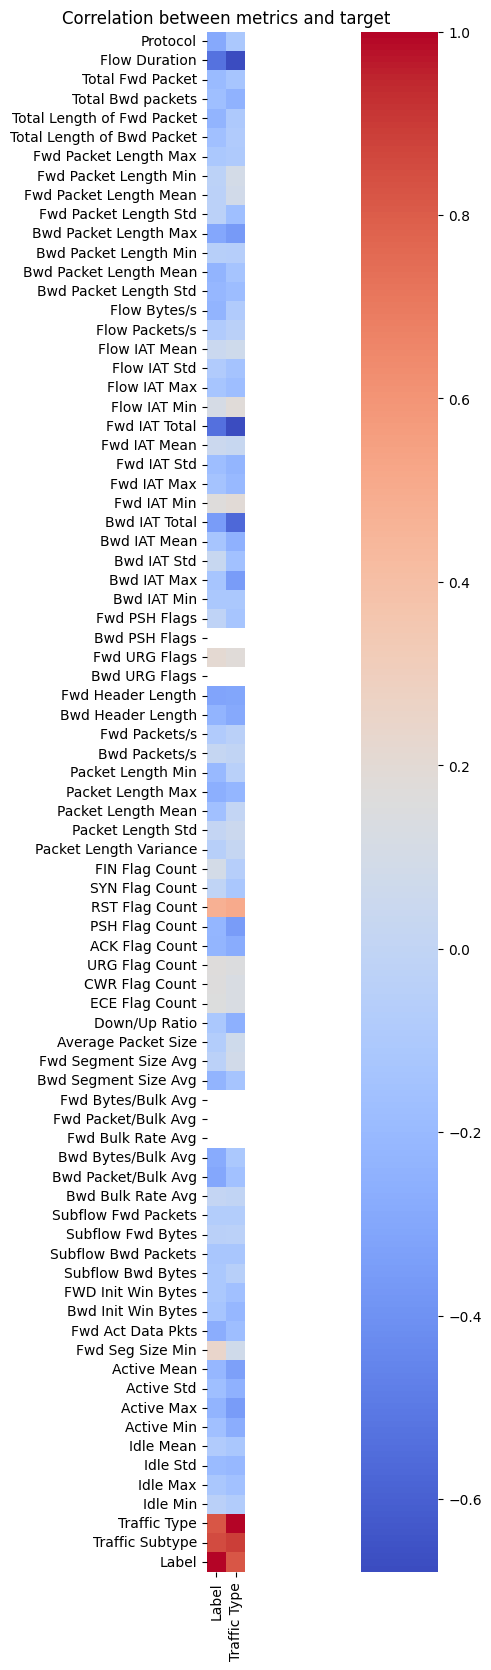

In [107]:
### Create heatmaps
heatmap(cor1, "Correlation between metrics")
heatmap(cor2, "Correlation between metrics and target")

Generating barplot ...


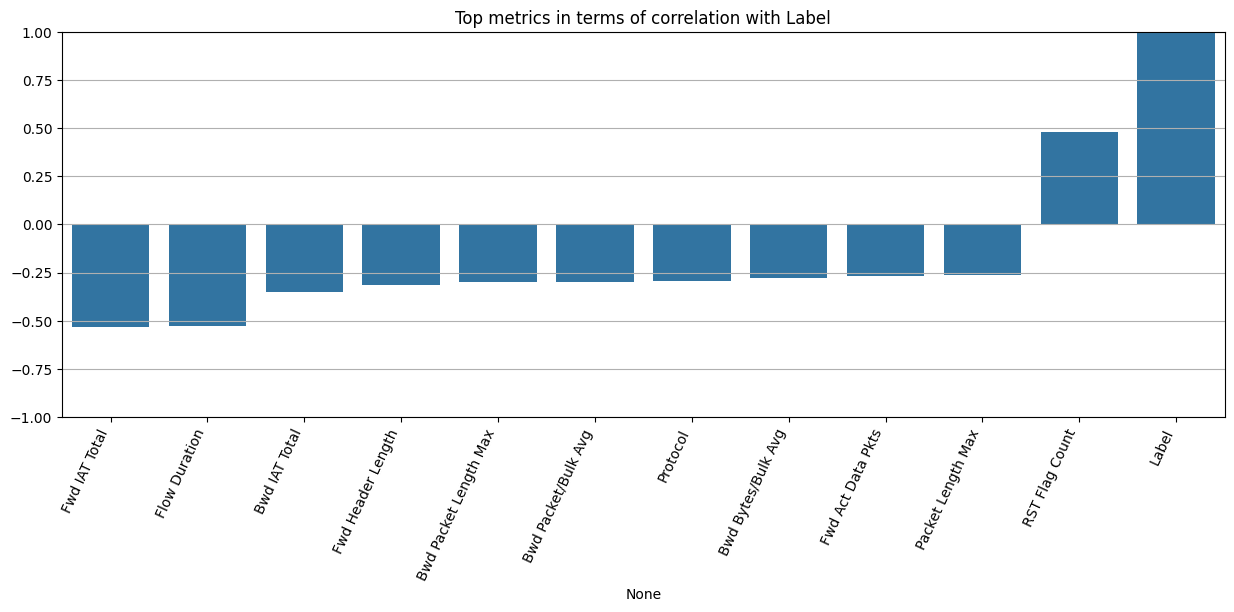

Generating barplot ...


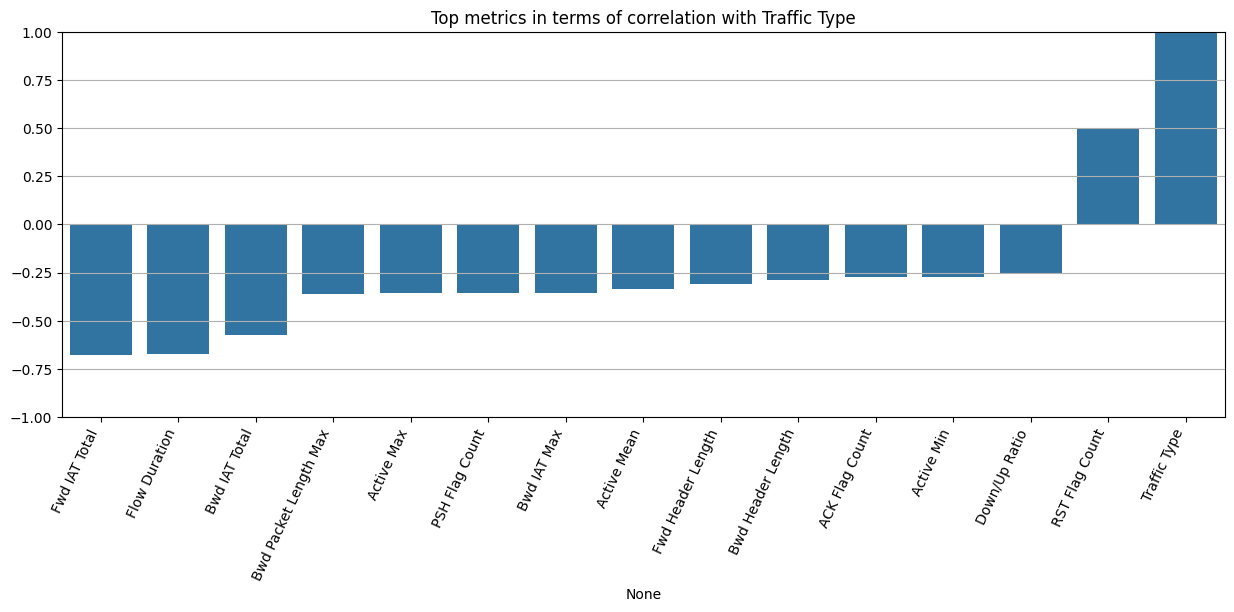

In [108]:
### Showcase top correlations
df_important_metrics_label_count = cor2.filter(items=label_barplot, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor2.filter(items=ttype_barplot, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [109]:
### DataFrames with metrics highly correlated with targets, dimension reduction
DIM_TARGET1 = 6
DIM_TARGET2 = 7
df_label = df_num[important_metrics_label].copy()
df_ttype = df_num[important_metrics_ttype].copy()

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), DIM_TARGET1, "PCA")
df_labelDimReduction["Label"] = df_label["Label"]
df_labelDimReduction["Traffic Type"] = df_label["Traffic Type"]
df_labelDimReduction["Traffic Subtype"] = df_label["Traffic Subtype"]
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), DIM_TARGET2, "PCA")
df_ttypeDimReduction["Label"] = df_ttype["Label"]
df_ttypeDimReduction["Traffic Type"] = df_ttype["Traffic Type"]
df_ttypeDimReduction["Traffic Subtype"] = df_ttype["Traffic Subtype"]


Target Label:
PCA METHOD --> Cumulative variance: 0.9542544779758877
Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.9556451890490145


In [ ]:
### Sampling, Clustering with BIRCH, Clustering with HDBSCAN
# Data reduction through sampling
df_label_sampling = sampling(df_labelDimReduction, 0, 0.3, notext=True)
df_ttype_sampling = sampling(df_ttypeDimReduction, 0, 0.3, notext=True)

# Data reduction through BIRCH clustering
print("BIRCH with target: Label")
df_label_BIRCH = BIRCH_clustering(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 20)
df_label_BIRCH["Label"] = df_labelDimReduction["Label"]
print("BIRCH with target: Traffic Type")
df_ttype_BIRCH = BIRCH_clustering(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 200)
df_ttype_BIRCH["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]

# Data reduction through HDBSCAN clustering
print("HDBSCAN with target: Label")
df_label_HDBSCAN = HDBSCAN_clustering(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 50)
df_label_HDBSCAN["Label"] = df_labelDimReduction["Label"]
print("HDBSCAN with target: Traffic Type")
df_ttype_HDBSCAN = HDBSCAN_clustering(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 25)
df_ttype_HDBSCAN["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]

BIRCH with target: Label
Davies-Bouldin Index: 0.52899770979515
BIRCH with target: Traffic Type
Davies-Bouldin Index: 0.12551097218486434
HDBSCAN with target: Label
Davies-Bouldin Index: 0.14262458904175296
HDBSCAN with target: Traffic Type
Davies-Bouldin Index: 0.090326252060596


BIRCH, target = Label:
Problematic Cluster Ratio: 0.1
Problematic Population Ratio: 0.2585562385778368
Clusters assigned to each Label --> {0: 17, 1: 3}
Problematic Clusters assigned to each Label --> {0: 2, 1: 0}
Total Clusters --> 20
Total Population predicted per Target --> {0: 14187, 1: 9889}
Actual population per Target --> {0: 12109, 1: 11967}


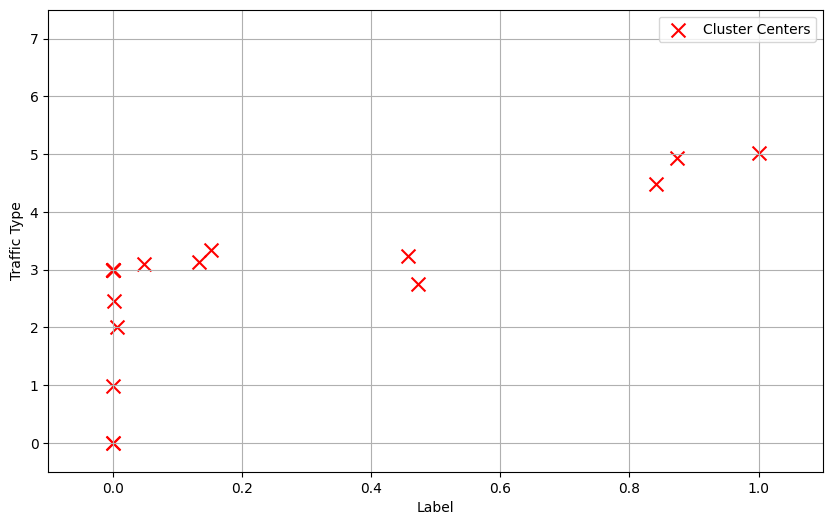

BIRCH, target = Traffic Type:
Problematic Cluster Ratio: 0.08426966292134831
Problematic Population Ratio: 0.7264080412028576
Clusters assigned to each Traffic Type --> {0: 49, 1: 0, 2: 51, 3: 36, 4: 8, 5: 12, 6: 0, 7: 6}
Problematic Clusters assigned to each Traffic Type --> {0: 2, 1: 0, 2: 2, 3: 8, 4: 1, 5: 2, 6: 0, 7: 0}
Total Clusters --> 178
Total Population predicted per Target --> {0: 1229, 1: 0, 2: 1460, 3: 9707, 4: 1678, 5: 9522, 6: 0, 7: 6}
Actual population per Target --> {0: 1944, 1: 319, 2: 1959, 3: 7887, 4: 2566, 5: 7475, 6: 1040, 7: 886}


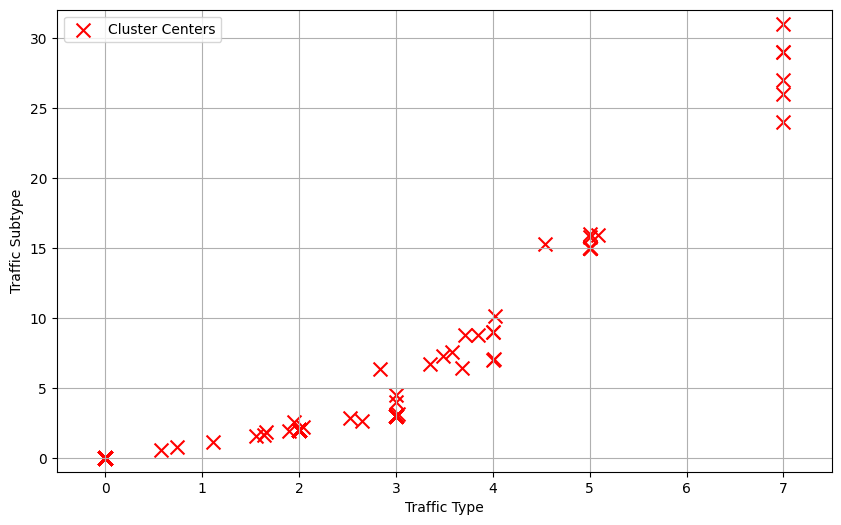

HDBSCAN, target = Label:
Problematic Cluster Ratio: 0.017699115044247787
Problematic Population Ratio: 0.00805781691310849
Clusters assigned to each Label --> {0: 67, 1: 45}
Problematic Clusters assigned to each Label --> {0: 0, 1: 2}
Total Clusters --> 113
Total Population predicted per Target --> {0: 10309, 1: 9864}
Actual population per Target --> {0: 12109, 1: 11967}


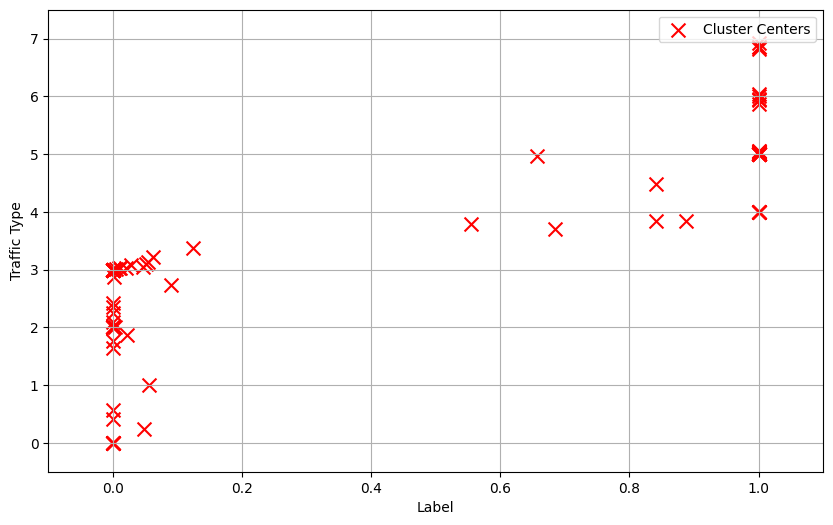

HDBSCAN, target = Traffic Type:
Problematic Cluster Ratio: 0.21201413427561838
Problematic Population Ratio: 0.18740654593786343
Clusters assigned to each Traffic Type --> {0: 29, 1: 6, 2: 30, 3: 137, 4: 11, 5: 56, 6: 3, 7: 10}
Problematic Clusters assigned to each Traffic Type --> {0: 8, 1: 3, 2: 8, 3: 16, 4: 1, 5: 21, 6: 2, 7: 1}
Total Clusters --> 283
Total Population predicted per Target --> {0: 1312, 1: 296, 2: 1575, 3: 6498, 4: 2354, 5: 5300, 6: 339, 7: 527}
Actual population per Target --> {0: 1944, 1: 319, 2: 1959, 3: 7887, 4: 2566, 5: 7475, 6: 1040, 7: 886}


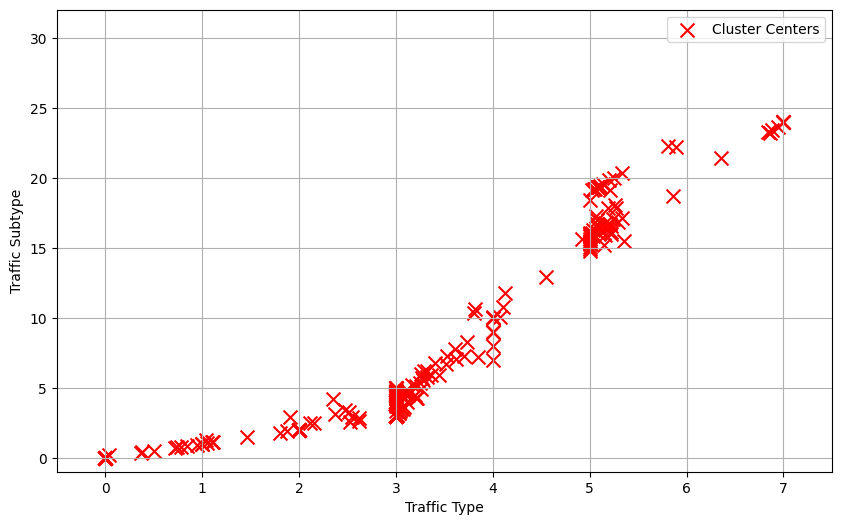

Problematic Population Ratio should be below 5%!


In [115]:
### Visualize clusters
df_label_BIRCH_plot = df_label_BIRCH.copy()
df_label_BIRCH_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_BIRCH_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]

df_ttype_BIRCH_plot = df_ttype_BIRCH.copy()
df_ttype_BIRCH_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_BIRCH_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]

df_label_HDBSCAN_plot = df_label_HDBSCAN.copy()
df_label_HDBSCAN_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_HDBSCAN_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]

df_ttype_HDBSCAN_plot = df_ttype_HDBSCAN.copy()
df_ttype_HDBSCAN_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_HDBSCAN_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]

print("BIRCH, target = Label:")
evaluate_clusters(df_label_BIRCH_plot, "Label", "Traffic Type", 2)
print("BIRCH, target = Traffic Type:")
evaluate_clusters(df_ttype_BIRCH_plot, "Traffic Type", "Traffic Subtype", 8)
print("HDBSCAN, target = Label:")
evaluate_clusters(df_label_HDBSCAN_plot, "Label", "Traffic Type", 2)
print("HDBSCAN, target = Traffic Type:")
evaluate_clusters(df_ttype_HDBSCAN_plot, "Traffic Type", "Traffic Subtype", 8)
print("Problematic Population Ratio should be below 5%!")

In [ ]:
print("Amount of Clusters:")
print("BIRCH ALGORITHM\n", df_label_BIRCH.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count(), "\n", df_ttype_BIRCH.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count())
print("HDBSCAN ALGORITHM\n", df_label_HDBSCAN.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count(), "\n", df_ttype_HDBSCAN.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count())